# 문화데이터 활용 경진대회 Python

1. Preprocessing & EDA
 1) Variables - 거리, 방문자수 계절 트렌드
 2) Crawling Data Tokenization
 3) EDA

2. Similarity
 1) Topic Modeling (LDA)
 2) Clustering - visualization
 3) Similarity
 
3. Recommendation System

In [1]:
# Library

import requests
import json
import pandas as pd
import numpy as np

import folium
from folium.plugins import MiniMap
from haversine import haversine, Unit
from geopy.distance import geodesic as GD


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import urllib.request
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import glob
import os
import ast
from konlpy.tag import Okt
okt=Okt()
import pickle

from sklearn.manifold import TSNE

from scipy.spatial import distance

import tkinter as tk
import pandas as pd
from tkinter import font as tkFont
from tkinter import ttk
from PIL import Image, ImageTk
from river import (
    stream,
    compose,
    preprocessing,
    evaluate,
    metrics,
    linear_model,
    imblearn,
    stats,
    optim 
)
import numbers

## 1. Preprocessing & EDA

### A. Variables

#### 거리

In [2]:
from PyKakao import Local
api = Local(service_key = "b4ce6014d1ced25f29acc92c5927ced9")
df = pd.DataFrame()

In [3]:
#시군구 총 228개


country = {'서울':['강남구','강동구','강북구','서울 강서구','관악구','광진구','구로구','금천구','노원구','도봉구','동대문구','동작구','마포구','서대문구','서초구','성동구','성북구','송파구','양천구','영등포구','용산구','은평구','종로구','서울 중구','중랑구'],
          '부산':['부산 강서구','금정구','기장군','부산 남구','부산 동구','동래구','부산진구','부산 북구','사상구','사하구','부산 서구','수영구','연제구','영도구','부산 중구','해운대구'],
          '대구':['대구 남구','달서구','달성군','대구 동구','대구 북구','대구 서구','수성구','대구 중구'],
          '인천':['강화군','계양구','남동구','인천 동구','미추홀구','부평구','인천 서구','연수구','옹진군','인천 중구'],
          '광주':['광산구','광주 남구','광주 동구','광주 북구','광주 서구'],
          '대전':['대덕구','대전 동구','대전 서구','유성구','대전 중구'],
          '울산':['울산 남구','울산 동구','울산 북구','울주군','울산 중구'],
          '경기':['가평군','고양시','과천시','광명시','광주시','구리시','군포시','김포시','남양주시','동두천시','부천시','성남시','수원시','시흥시','안산시','안성시','안양시','양주시','양평군','여주시','연천군','오산시','용인시','의왕시','의정부시','이천시','파주시','평택시','포천시','하남시','화성시'],
          '강원':['강릉시','강원 고성군','동해시','삼척시','속초시','양구군','양양군','영월군','원주시','인제군','정선군','철원군','춘천시','태백시','평창군','홍천군','화천군','횡성군'],
          '충북':['괴산군','단양군','보은군','영동군','옥천군','음성군','제천시','증평군','진천군','청주시','충주시'],
          '충남':['계룡시','공주시','금산군','논산시','당진시','보령시','부여군','서산시','서천군','아산시','예산군','천안시','청양군','태안군','홍성군'],
          '전북':['고창군','군산시','김제시','남원시','무주군','부안군','순창군','완주군','익산시','임실군','장수군','전주시','정읍시','진안군'],
          '전남':['강진군','고흥군','곡성군','광양시','구례군','나주시','담양군','목포시','무안군','보성군','순천시','신안군','여수시','영광군','영암군','완도군','장성군','장흥군','진도군','함평군','해남군','화순군'],
          '경북':['경산시','경주시','고령군','구미시','군위군','김천시','문경시','봉화군','상주시','성주군','안동시','영덕군','영양군','영주시','영천시','예천군','울릉군','울진군','의성군','청도군','청송군','칠곡군','포항시'],
          '경남':['거제시','거창군','경남 고성군','김해시','남해군','밀양시','사천시','산청군','양산시','의령군','진주시','창녕군','창원시','통영시','하동군','함안군','함양군','합천군'],
          '제주':['서귀포시','제주시']}

In [5]:
import warnings
warnings.filterwarnings('ignore')

for val in country.values():
    for j in val:
        new = api.search_address(j, dataframe=True)
        df = df.append(new.iloc[0])

In [6]:
df = df.loc[:,["address_name","x","y"]]
df = df.reset_index(drop=True)
df.head(5)

,address_name,x,y
0,서울 강남구,127.047377408384,37.517331925853
1,서울 강동구,127.123792501252,37.5301933196157
2,서울 강북구,127.025538071854,37.6397513275882
3,서울 강서구,126.849533759514,37.5509646154244
4,서울 관악구,126.951561853868,37.4783683761333


##### 출발지(학교)로부터의 거리

- 성균관대학교를 출발지로 설정함

In [7]:
start = api.search_address("종로구 성균관로 25-2", dataframe=True).loc[:,["address_name","x","y"]]

In [8]:
s = (float(start.loc[0,"y"]), float(start.loc[0,"x"]))
s

(37.5872284082508, 126.993115116294)

In [9]:
for i in range(len(df)):
    x = df.loc[i, "x"]
    y = df.loc[i, "y"]
    geo = (float(y), float(x))
    dis = haversine(s, geo, unit="km")
    df.loc[i, "거리"] = dis

In [10]:
df.head(5)

,address_name,x,y,거리
0,서울 강남구,127.047377408384,37.517331925853,9.126233
1,서울 강동구,127.123792501252,37.5301933196157,13.149377
2,서울 강북구,127.025538071854,37.6397513275882,6.501167
3,서울 강서구,126.849533759514,37.5509646154244,13.281504
4,서울 관악구,126.951561853868,37.4783683761333,12.647107


##### 각 여행지끼리의 거리

- Distance Matrix

neighbor의 경우 가중치를 주어 점수에 같이 계산하기 위해 weighted matrix 형성을 위한 distance matrix

In [11]:
n = len(df)
distance_matrix = pd.DataFrame(index=df['address_name'], columns=df['address_name'])

for i in range(n):
    for j in range(n):
        a = (float(df.loc[i, 'y']), float(df.loc[i, 'x']))
        b = (float(df.loc[j, 'y']), float(df.loc[j, 'x']))
        distance_matrix.at[df.loc[i, 'address_name'], df.loc[j, 'address_name']] = haversine(a, b, unit="km")

In [12]:
distance_matrix

address_name,서울 강남구,서울 강동구,서울 강북구,서울 강서구,서울 관악구,서울 광진구,서울 구로구,서울 금천구,서울 노원구,서울 도봉구,...,경남 진주시,경남 창녕군,경남 창원시,경남 통영시,경남 하동군,경남 함안군,경남 함양군,경남 합천군,제주특별자치도 서귀포시,제주특별자치도 제주시
address_name,,,,,,,,,,,,,,,,,,,,,
서울 강남구,0.0,6.889041,13.747813,17.841536,9.498468,3.886028,14.310913,14.997263,15.25791,16.830436,...,276.675765,254.513246,293.618116,321.146375,279.63765,277.677367,230.145738,238.804699,476.110151,449.19357
서울 강동구,6.889041,0.0,14.94546,24.291171,16.248984,3.767763,21.196347,21.733408,15.028529,16.813359,...,275.75542,252.365355,291.519682,319.880715,279.572947,276.046762,229.833256,237.342485,478.224117,451.384276
서울 강북구,13.747813,14.94546,0.0,18.382799,19.093018,12.316662,20.137728,23.349022,3.16812,3.741076,...,290.12041,267.233834,306.378679,334.435382,293.331372,290.75855,243.78488,251.982056,489.48792,462.535733
서울 강서구,17.841536,24.291171,18.382799,0.0,12.088916,20.575425,7.024409,11.222699,21.549904,21.784601,...,286.669394,267.015027,305.963154,331.789242,287.744119,289.132184,238.94069,250.002226,478.515564,451.418493
서울 관악구,9.498468,16.248984,19.093018,12.088916,0.0,13.339965,5.961891,5.499811,21.642583,22.780003,...,275.72568,255.318747,294.31285,320.638094,277.515376,277.720157,228.417518,238.655166,471.063229,444.059289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
경남 함안군,277.677367,276.046762,290.75855,289.132184,277.720157,278.446503,282.108459,278.025913,291.068899,292.855903,...,29.012206,31.245933,25.486871,46.540879,63.772455,0.0,67.639362,39.322409,281.371861,261.668796
경남 함양군,230.145738,229.833256,243.78488,238.94069,228.417518,231.626322,232.007546,227.723801,244.666617,246.411599,...,51.337931,69.457178,92.639152,98.107481,50.45185,67.639362,0.0,40.195469,273.770228,249.933727
경남 합천군,238.804699,237.342485,251.982056,250.002226,238.655166,239.66544,242.977819,238.873987,252.370958,254.155713,...,43.292573,29.62669,60.054353,82.83702,67.06318,39.322409,40.195469,0.0,296.362987,274.313138


#### 방문자수 계절성

In [13]:
data = pd.read_csv("방문자수 19_23(수정).csv")

In [14]:
data1 = data.copy()
region = data1.iloc[:, :2]
region = region.assign(col1='', col2='', col3='', col4='', col5='', col6='', col7='', col8='', col9='', col10='', col11='', col12='')

In [15]:
data1 = data1.drop(data1.columns[0], axis=1)
data1 = data1.drop(data1.columns[0], axis=1)
data1

,방문자수 19-1,방문자수 19-2,방문자수 19-3,방문자수 19-4,방문자수 19-5,방문자수 19-6,방문자수 19-7,방문자수 19-8,방문자수 19-9,방문자수 19-10,...,방문자수 22-6,방문자수 22-7,방문자수 22-8,방문자수 22-9,방문자수 22-10,방문자수 22-11,방문자수 22-12,방문자수 23-1,방문자수 23-2,방문자수 23-3
0,696582,741978.0,775665,746861,786532,889444,1060221,1539314,815551,883643,...,2990000.0,3551243.0,4026350.0,2975029.0,3321197.0,2602272.0,2529498.0,2876665.0,2718362.0,2999758.0
1,2112538,2179394.0,2772843,2125210,2300105,2466090,2710265,3327273,2855453,2638383,...,1244150.0,1514965.0,1745926.0,1118488.0,1253871.0,854915.0,920543.0,901829.0,880512.0,848900.0
2,2181409,2217946.0,2751359,2032502,2218640,2418354,2744410,3422557,2879305,2564137,...,967369.0,1228212.0,1264125.0,1095333.0,1130337.0,988903.0,847918.0,1024499.0,848962.0,924943.0
3,2538092,2553697.0,2744947,2030935,2305446,2507693,2901443,4356849,2767816,2493071,...,970128.0,1268362.0,1424061.0,1078454.0,1095231.0,864314.0,746897.0,874395.0,754208.0,975015.0
4,815823,807114.0,822741,713977,791667,813621,982952,1405017,948057,907332,...,2189126.0,2630076.0,3005110.0,2007349.0,2528720.0,1917300.0,1894441.0,1914417.0,1913547.0,1670923.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,823671,821839.0,1009464,950458,1043778,938264,963807,940902,1019203,973471,...,1267337.0,1469336.0,1548654.0,1440008.0,1524121.0,1209903.0,940036.0,1065596.0,939855.0,1250775.0
224,449843,598113.0,708537,661400,777842,809041,910731,1125719,891388,794626,...,485260.0,509548.0,494713.0,540892.0,590890.0,466214.0,422266.0,445057.0,407978.0,519287.0
225,1101215,1162639.0,1430693,1254046,1415319,1266298,1333298,1391666,1461576,1328349,...,1086448.0,1143720.0,1111924.0,1219406.0,1178951.0,1057783.0,878049.0,936543.0,888681.0,1125751.0
226,475244,613806.0,574337,685516,846620,728714,718902,1041877,709245,856893,...,9888532.0,10458453.0,10178983.0,11316693.0,10811416.0,10008860.0,9719088.0,10100852.0,9436899.0,11850391.0


In [16]:
data1 = data1.transpose()

In [17]:
for col in data1.columns:
    
    start_date = pd.Timestamp(year=2019, month=1, day=1)
    end_date = pd.Timestamp(year=2023, month=3, day=1)
    idx = pd.date_range(start=start_date, end=end_date, freq='MS')
    region_data = pd.DataFrame({col: data1[col].values}, index=idx)
    
    # 시계열 분해(덧셈 분해)
    decomposition = seasonal_decompose(region_data, model='additive', period=12)
    a = decomposition.seasonal.values[0:12]
    a = a.transpose()
    region.loc[col, 'col1':'col12'] = decomposition.seasonal.values[0:12]

In [18]:
#min-max 스케일링 진행
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

df = region.copy()
df.iloc[:,2:] = df.iloc[:,2:].apply(normalize, axis=0)

In [19]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

month = ["1","2","3","4","5","6","7","8","9","10","11","12"]

In [20]:
df.head

<bound method NDFrame.head of     광역지자체명 기초지자체명      col1      col2      col3      col4      col5      col6  \
0      강원도    고성군  0.682136  0.807787  0.615682  0.602856  0.229635  0.556251   
1      강원도    춘천시  0.538924  0.673271  0.555386  0.494376  0.199598  0.479993   
2      강원도    원주시  0.574904  0.683852  0.554508  0.491953   0.19101  0.446991   
3      강원도    강릉시  0.548986  0.674926   0.49784  0.455261  0.174688  0.500371   
4      강원도    동해시  0.673572   0.79987  0.601409  0.588356  0.243755  0.513115   
..     ...    ...       ...       ...       ...       ...       ...       ...   
223   충청북도    진천군  0.603853  0.777752   0.66783  0.605285  0.246647  0.512917   
224   충청북도    괴산군  0.588489  0.775865  0.649925   0.58194   0.20108  0.457426   
225   충청북도    음성군  0.597509  0.765472  0.672917  0.595266  0.223481  0.503714   
226   충청북도    단양군  0.917734  0.942225  0.935481   0.83424  0.693006  0.540305   
227   충청북도    청주시  0.239703  0.308593  0.374565  0.283421  0.263573  0.374372  

### B. Crawling Data Tokenization

토큰화는 오랜 시간이 걸리므로 주석 처리 했습니다.

In [21]:
#data = pd.read_csv("국내여행지_크롤링.csv", encoding='utf-8')
#text = data[['내용']]
#text['내용'] = text.apply(lambda row: okt.nouns(row['내용']) if isinstance(row['내용'], str) else [], axis=1)

In [22]:
#data = pd.read_csv("해외여행지_크롤링.csv", encoding='utf-8')
#text = data[['내용']]
#text['내용'] = text.apply(lambda row: okt.nouns(row['내용']) if isinstance(row['내용'], str) else [], axis=1)

### C. EDA

In [23]:
#클러스터링 진행
for_cluster = df.drop(df.columns[0], axis=1)
for_cluster = for_cluster.drop(for_cluster.columns[0], axis=1)

cluster_n = 4

kmeans = KMeans(n_clusters=cluster_n, n_init=1)
kmeans.fit(for_cluster)

df['cluster'] = kmeans.labels_

In [24]:
def plot_cluster_seasonal_trends(cluster_data, cluster_label):
    cluster = cluster_data[cluster_data['cluster'] == cluster_label]
    
    fig, ax = plt.subplots(figsize=(12,6))
    for city in cluster.index:
        city_seasonal_trend = cluster.loc[city].iloc[2:-1]
        sns.lineplot(x=city_seasonal_trend.index, y=city_seasonal_trend.values, label=city, alpha=0.7)
    
    plt.title(f'Seasonal Trend for Cluster {cluster_label}')
    plt.xlabel('Month')
    plt.ylabel('Seasonal Trend')
    ax.get_legend().remove()
    plt.show()

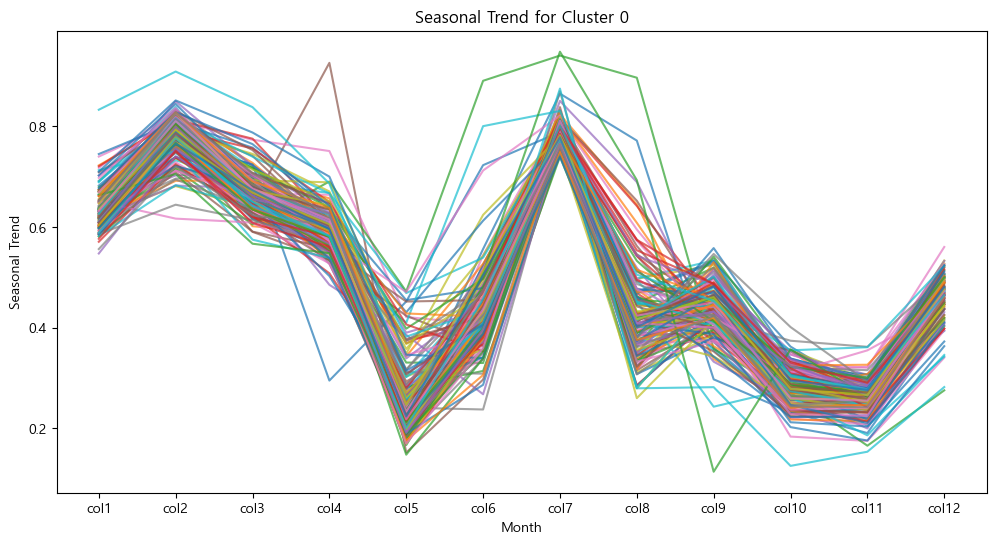

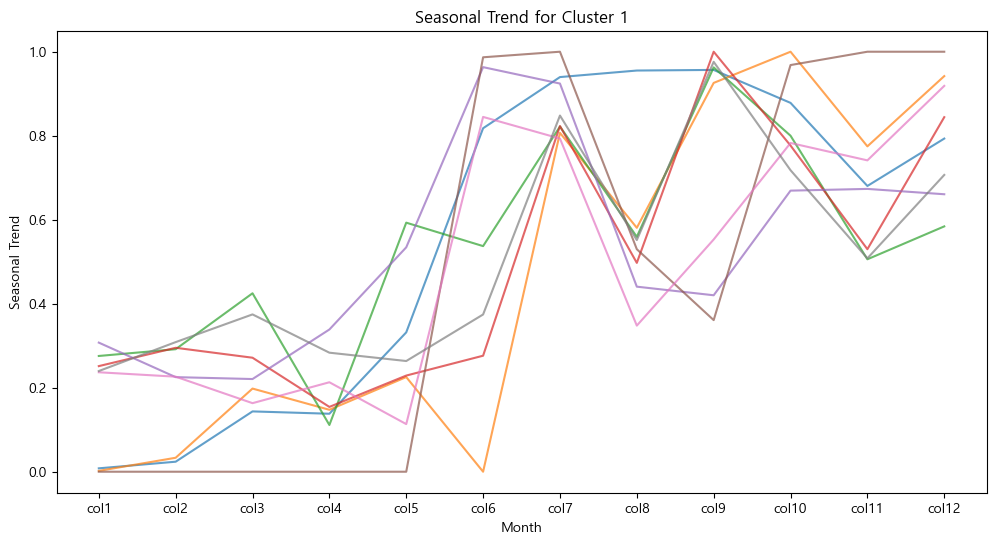

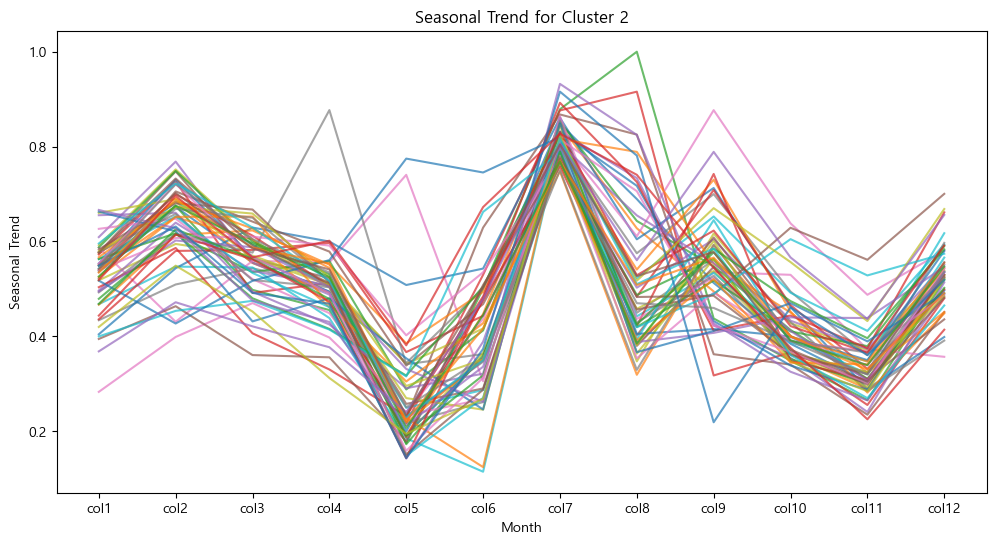

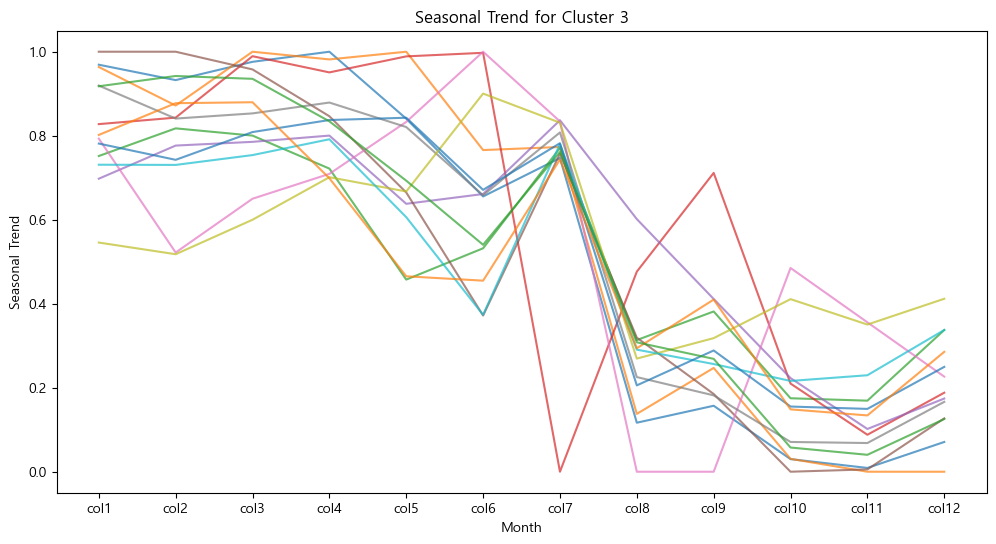

In [25]:
for i in range(cluster_n):
    plot_cluster_seasonal_trends(df, i)

## 2. Similarity

### A. Topic Modeling (LDA)

In [26]:
city_names = ['강남','강동','강북','강서','관악','광진','구로','금천','노원','도봉','동대문','동작','마포','서대문','서초','성동','성북','송파','양천','영등포','용산','은평','종로','중구','중랑','강서','금정','기장','남구','동구','동래','부산진','북구','사상','사하','서구','수영','연제','영도','중구','해운대',
                       '광산','남구','동구','북구','서구','강화','계양','남동','동구','미추홀','부평','서구','연수','옹진','중구',
                       '대덕','동구','서구','유성','중구',
                       '가평','고양','과천','광명','광주','구리','군포','김포','남양주','동두천','부천','성남','수원','시흥','안산','안성','안양','양주','양평','여주','연천','오산','용인','의왕','의정부','이천','파주','평택','포천','하남','화성',
                       '남구','달서','달성','동구','북구','서구','수성','중구',
                       '남구','동구','북구','울주','중구',
                       '세종','강릉','고성','동해','삼척','속초','양구','양양','영월','원주','인제','정선','철원','춘천','태백','평창','홍천','화천','횡성',
                       '괴산','단양','보은','영동','옥천','음성','제천','증평','진천','청주','충주',
                       '계룡','공주','금산','논산','당진','보령','부여','서산','서천','아산','예산','천안','청양','태안','홍성',
                       '고창','군산','김제','남원','무주','부안','순창','완주','익산','임실','장수','전주','정읍','진안',
                       '강진','고흥','곡성','광양','구례','나주','담양','목포','무안','보성','순천','신안','여수','영광','영암','완도','장성','장흥','진도','함평','해남','화순',
                       '경산','경주','고령','구미','군위','김천','문경','봉화','상주','성주','안동','영덕','영양','영주','영천','예천','울릉','울진','의성','청도','청송','칠곡','포항',
                       '거제','거창','고성','김해','남해','밀양','사천','산청','양산','의령','진주','창녕','창원','통영','하동','함안','함양','합천',
                       '서귀포','제주',
                       '오사카','도쿄','후쿠오카','삿포로','오키나와','교토','나고야','유후','고베','요코하마',
                       '상하이','톈진','베이징','칭다오','장자제','광저우','하얼빈','하이난','샤먼','시안',
                       '다낭','냐짱','호찌민','푸꾸옥','하노이','달랏','호이안',
                       '방콕','푸껫','치앙마이','파타야','코사무이','크라비','후아힌',
                       '세부','보라카이','보홀','마닐라','팔라완',
                       '홍콩','타이페이','가오슝','타이중','타이난','화롄',
                       '마카오','싱가포르','코타키나발루','쿠알라룸푸르',
                       '발리','자카르타','롬복','빈탄섬','프라하',"바르셀로나", "마요르카", "마드리드", "세비야", "그라나다",
                       "프랑크푸르트", "뮌헨", "베를린", "함부르크", "드레스덴", "쾰른", "하이델베르크",
                       "빈", "잘츠부르크", "할슈타트",'블라디보스토크','모스크바','상트페테르부르크',
                       "런던", "에든버러","본머스","글래스고","리버풀","맨체스터","옥스퍼드",'암스테르담','헤이그','로테르담',
                       '파리','니스','마르세유','스트라스부르','보르도','몽생미셸','콜마르','리옹','아를','아비뇽',
                       '뉴욕','LA','샌프란시스코','라스베이거스','시카고','시애틀','워싱턴','보스턴','샌디에이고','괌','오하우','빅아일랜드',
                       '로마','피렌체','밀라노','베네치아','나폴리','시칠리아',
                       '시드니','멜버른','브리즈번','골드코스트','퍼스','캔버라','케언즈','애들레이드','율라라',
                       '케이프타운','요하네스버그','밴쿠버','토론토','오타와','퀘벡','몬트리올','나이아가라폭포시티',
                       '인터라켄','취리히','루체른','그린델발트','베른','체르마트','제네바','몽트뢰','라우터브루넨',
                       '부다페스트']

country_names = ['일본','중국','베트남','태국','필리핀','홍콩','대만','마카오','싱가포르','말레이시아',
                 '인도네시아','체코','스페인','독일','오스트리아','러시아','영국','네덜란드','프랑스',
                 '미국','이탈리아','호주','남아프리카공화국','캐나다','스위스','헝가리','서울',
                 '부산','광주','인천','대전','경기','대구','울산','세종','강원',
                 '충북','충남','전북','전남','경북','경남','제주']

In [27]:
# pickle file
with open('okt_불용어제거_해외국내_토큰.pkl', 'rb') as f:
    loaded3_df = pickle.load(f)
#해외 데이터만 따로
overseas = loaded3_df[0:60349]

In [28]:
def clean_punc(text, punct, mapping, unique): 
    for p in mapping: 
        text = text.replace(p, "") 
    for p in punct: 
        text = text.replace(p, "")
    for p in unique:
        text = text.replace(p, "")
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials: 
        text = text.replace(s, "") 
    return text.strip()


punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'+'↑↓▼▲▶◆♥·'
punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', '∅': '', '³': '3', 'π': 'pi' }

remove_word = np.array(["여행", "계획", "자유여행", "사람","톨레도","예약","이동",
                       "공항","사진","일정","숙소","투어","추천","방문",
                       "생각","때문","도착","이용","정도","코스","주문","페이지",
                        "유럽","다시","구경","호이안","괴테","그냥","모습","한국",
                       "블로그", "오늘", "공지", "위치", "보고", "재생", "목록",
                        "버스",'시작', '처음', '준비', '댓글', '타고', '느낌','주차장',
                       '발트', '융프라우','나트랑','그린','스코틀랜드','알함브라',
                       '블로거','공감','패스', '라스베가스', '기차','엄마',
                       '후기', '보기', '메모', '전체' ,'화면', '작성', '비행기',
                        '택시', '출발', '미리','가격','사용','방법','확인','경우',
                        '체크','티켓','구매','인쇄','카테고리','최상','이전','직원',
                       '정보','포함','이제','사실', '포스팅', '이유','선택','한번','지금','친구',
                       '세계', '제목', '지역', '날씨', '관광','위해','항공권', "하와이",
                        "마지막", "카드", "탑승",'불가','지하철', '항공',
                       "도시","패키지","여행지",'진행'])
#remove_word는 불용어는 아닌데 토픽으로 잡히면 해석하기 어려운 단어
#도시, 나라 이름 또한 토픽으로 잡힐 확률이 높아서 삭제
unique = city_names
unique = list(np.append(unique, country_names))
unique = list(np.append(unique, remove_word))
unique = {string : "" for string in unique}

In [29]:
filtered_text = []

for sentence in overseas['내용']:
    filtered_sentence = [word for word in sentence if word not in unique]
    filtered_text.append(filtered_sentence)
    
overseas["내용"] = filtered_text
over_tokenized_doc = overseas['내용']

In [30]:
# 역토큰화 (토큰화 작업을 되돌림)
over_detokenized_doc = []
for i in range(len(overseas)):
    t = ' '.join(over_tokenized_doc[i])
    over_detokenized_doc.append(t)

In [31]:
### max_feature는 tf-idf vector의 최대 feature를 설정해주는 파라미터
vectorizer = TfidfVectorizer(max_features=150)
X_over = vectorizer.fit_transform(over_detokenized_doc)

# TF-IDF 행렬의 크기 확인
print('TF-IDF 행렬의 크기 :',X_over.shape)

TF-IDF 행렬의 크기 : (60349, 150)


In [32]:
#LDA 토픽 개수는 혼잡도 등을 고려하여 결정

lda_model = LatentDirichletAllocation(n_components=6,learning_method='batch',random_state=777,max_iter=30)

In [33]:
lda_top_over = lda_model.fit_transform(X_over)

In [34]:
terms = vectorizer.get_feature_names()

def get_topics(components, feature_names, n=7):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])

get_topics(lda_model.components_,terms)

Topic 1: [('리조트', 1916.88), ('비치', 1443.76), ('수영장', 1140.5), ('바다', 1084.89), ('해변', 1044.73), ('마사지', 1036.08), ('객실', 1022.48)]
Topic 2: [('마켓', 1102.9), ('야시장', 901.02), ('쇼핑', 876.39), ('시장', 802.3), ('거리', 547.36), ('구입', 543.52), ('기념품', 426.42)]
Topic 3: [('맛집', 2001.77), ('메뉴', 1599.96), ('음식', 1459.03), ('커피', 1423.92), ('카페', 1350.51), ('맥주', 1239.94), ('식당', 1151.78)]
Topic 4: [('마을', 1396.28), ('호수', 1291.96), ('풍경', 1198.49), ('공원', 1002.1), ('열차', 968.5), ('전망대', 743.99), ('겨울', 634.97)]
Topic 5: [('성당', 1673.96), ('광장', 1611.68), ('대성당', 1247.46), ('궁전', 1000.67), ('야경', 965.37), ('건물', 867.74), ('다리', 802.93)]
Topic 6: [('박물관', 1369.41), ('가이드', 1189.33), ('미술관', 1007.41), ('작품', 908.6), ('파크', 726.15), ('역사', 723.24), ('공연', 722.78)]


In [35]:
overseas_data = pd.concat([overseas[["country","city"]], pd.DataFrame(lda_top_over)],axis=1)
overseas_city_topic = overseas_data.groupby(["country","city"]).mean().reset_index().copy()
overseas_city_topic

,country,city,0,1,2,3,4,5
0,남아프리카공화국,요하네스버그,0.099022,0.099754,0.313179,0.128189,0.053696,0.306159
1,남아프리카공화국,케이프타운,0.154944,0.067494,0.328794,0.221184,0.051321,0.176264
2,네덜란드,로테르담,0.040427,0.179278,0.242250,0.154351,0.147905,0.235789
3,네덜란드,암스테르담,0.043662,0.102179,0.244954,0.127401,0.140370,0.341435
4,네덜란드,헤이그,0.063047,0.071375,0.184957,0.158338,0.095558,0.426724
...,...,...,...,...,...,...,...,...
130,호주,율라라,0.502015,0.037420,0.128391,0.172402,0.075690,0.084082
131,호주,캔버라,0.070856,0.065541,0.269818,0.255466,0.044511,0.293808
132,호주,케언즈,0.225715,0.097799,0.192507,0.260180,0.034170,0.189630
133,호주,퍼스,0.146781,0.115683,0.273998,0.267310,0.046639,0.149588


### B. Clustering Visualization

Compositional Data Clustering이 잘 진행되었는지 시각적으로 확인하기 위해 고차원 시각화가 가능한 t-SNE 사용

In [36]:
data = pd.read_csv("유형 트렌드 compositionaldata.csv", encoding="cp949")
X = data.drop(["광역","기초"], axis=1)

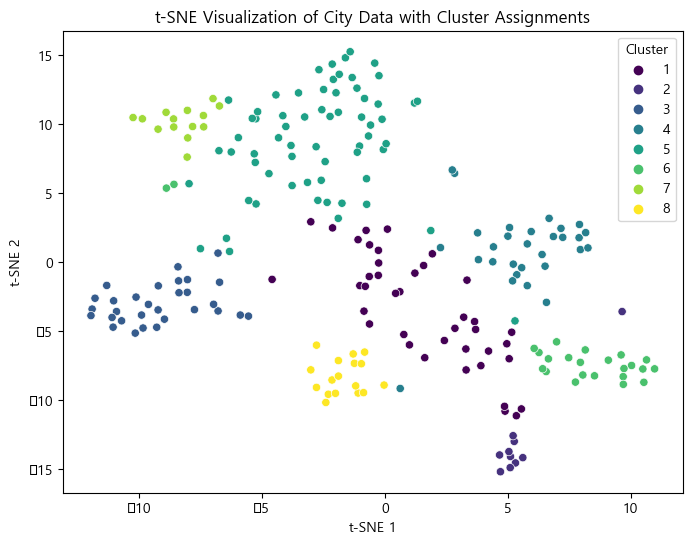

In [37]:
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
data_tsne = tsne.fit_transform(data.iloc[:,4:15])

df_tsne = pd.DataFrame(data_tsne, columns=['x', 'y'])
df_tsne['City'] = data["기초"]
df_tsne['Cluster'] = data["cluster"]


plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tsne, x='x', y='y', hue='Cluster', palette='viridis', legend='full')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Visualization of City Data with Cluster Assignments')
plt.show()

### C. Similarity Score

해외 도시 토픽 비율은 LDA를 통해 나온 각 토픽 비율

국내 도시는 검색 카테고리를 해외 토픽에 대응시킨 비율

In [38]:
# 데이터
overseas_topic = pd.read_csv("LDA해외비율.csv", encoding="cp949")
domestic_topic = pd.read_csv("국내_토픽_파이널.csv", encoding="cp949")
domestic_topic2 = pd.DataFrame(domestic_topic.drop(["광역",'기초'],axis=1))

In [39]:
js = pd.DataFrame(index=range(0,228), columns=range(0,135))

for j in range(len(overseas_topic)):
    city = np.array(overseas_topic.iloc[j,2:8]).flatten().tolist()
    for i in range(len(domestic_topic2)):
        js.iloc[i,j] = distance.jensenshannon(city, domestic_topic2.loc[i])

In [40]:
# 국내 도시와 해외 도시의 유사도 행렬
js.columns = overseas_topic['city'].values
js = pd.concat([domestic_topic.iloc[:,0:2], js], axis=1)
js.head()

,광역,기초,요하네스버그,케이프타운,로테르담,암스테르담,헤이그,가오슝,타이난,타이중,...,골드코스트,멜버른,브리즈번,시드니,애들레이드,율라라,캔버라,케언즈,퍼스,홍콩
0,강원,강릉시,0.285988,0.188094,0.344498,0.358648,0.357206,0.275676,0.270126,0.300246,...,0.102681,0.235117,0.178968,0.210459,0.218299,0.128669,0.299897,0.162475,0.192601,0.291629
1,강원,고성군,0.398708,0.311518,0.454293,0.449036,0.41658,0.400308,0.410369,0.427317,...,0.204302,0.346546,0.296474,0.328686,0.336405,0.115576,0.379015,0.251081,0.317905,0.424787
2,강원,동해시,0.492476,0.395081,0.518044,0.536881,0.509006,0.433614,0.472437,0.470153,...,0.288216,0.408032,0.373414,0.405678,0.404332,0.221666,0.456832,0.316779,0.370277,0.499963
3,강원,삼척시,0.497579,0.39163,0.526648,0.541995,0.511837,0.45055,0.48148,0.478868,...,0.308173,0.410351,0.382057,0.419389,0.404463,0.254085,0.448493,0.325227,0.370833,0.513464
4,강원,속초시,0.361564,0.268355,0.393617,0.431752,0.442571,0.292668,0.309431,0.326246,...,0.207097,0.297593,0.259386,0.282842,0.28491,0.217275,0.375934,0.244799,0.246784,0.342176


## 3. Recommendation System

In [41]:
#도시별 데이터
reg = pd.read_csv('데이터셋_v12.csv', encoding = 'cp949')
data = reg.iloc[:,2:]
data["도시"] = 0
data["동반"] = 0

compan = reg.iloc[:,4:9]

#유사도
sim = pd.read_csv("JSscore_해외국내도시.csv", encoding='cp949')
domestic =  pd.DataFrame()
domestic['city_province'] = sim['광역'] + '-' + sim['기초']

#공간가중치
spatial = pd.read_csv("공간가중행렬.csv", encoding='cp949')

In [45]:
window = tk.Tk()
window.title("Recommendation")
window.configure()

# 폰트 설정
helv36 = tkFont.Font(family='Helvetica', size=14, weight=tkFont.BOLD)
helv26 = tkFont.Font(family='Helvetica', size=12)

# 입력 칸 생성
city_label = tk.Label(window, text="Enter the city:", fg='black', font=helv36)
city_label.grid(row=0, column=0, padx=5, pady=5)

city_entry = tk.Entry(window)
city_entry.grid(row=0, column=1, padx=5, pady=5)

companion_label = tk.Label(window, text="Enter the companion type:",fg='black', font=helv36)
companion_label.grid(row=1, column=0, padx=5, pady=5)

companion_entry = tk.Entry(window)
companion_entry.grid(row=1, column=1, padx=5, pady=5)

# 선호도 입력
preferences = []
good=['불만족','만족']

column = ['거리','언급 트렌드','6월 계절트렌드','여행지 지명도','해외 유사도','동반 유형']

for i in range(6):
    frame = tk.Frame(window)
    frame.grid(row=i+2, column=0, padx=5, pady=5)

    label = tk.Label(frame, text=f"{column[i]} 선호도:")
    label.pack(side="left")

    var = tk.IntVar()
    preferences.append(var)

    for val in range(-2, 3):
        rb = tk.Radiobutton(frame, text=str(val), variable=var, value=val)
        rb.pack(side="left")

model = linear_model.LogisticRegression(optim.SGD(lr=0.01))
metric = metrics.ROCAUC()

input_data = []
outlabel_list = []
iloveit_list = []

# 추천 시스템
def calculate_data():
    global data
    
    output_label.config(text="")
    modified_output_label.config(text="")

    # 희망도시 입력값 불러오기
    city = city_entry.get()
    if city in sim.columns:
        data.iloc[:,-2] = sim[city]

    # 동반자 유형 입력값 불러오기
    companion = companion_entry.get()
    if companion in compan.columns:
        data.iloc[:,-1] = compan[companion]

    #데이터, 공간가중행렬 inner product  
    data = pd.DataFrame(np.dot(spatial, data))
    
    # 선호도 입력값 불러오기
    prefs = []
    for var in preferences:
        pref = var.get()
        prefs.append(pref)

    # 선호도와 각 요소별 데이터 가중합 구하기
    result = [0,0,0,0,0,0]  
    for i in range(6): 
        result[i] = data.iloc[:,i] * prefs[i] 

    result = pd.DataFrame(result)
    col_sums = [result[col].sum() for col in result.columns]

    domestic['선호도결과'] = col_sums
    global sorted_Re
    sorted_Re = domestic.sort_values('선호도결과', ascending=False)
    
    global modified2
    modified2 = sorted_Re
    output_text = "Top 10 rows:\n"
       
    #추천 만족 입력받기
    for i in range(10):
        output_text = str(sorted_Re.iloc[i,0])
        out = tk.Frame(window)
        out.grid(row=i+11, column=0, padx=5, pady=5)
        
        outlabel = tk.Label(out, text= str(i+1) + '.' + output_text + " | 추천 만족도를 입력해주세요:")
        outlabel.pack(side="left")
        outlabel_list.append(outlabel)
        
        love = tk.IntVar()
        input_data.append(love)
        
        for val in range(2):
            iloveit = tk.Radiobutton(out, text=good[val], variable=love, value=val)
            iloveit.pack(side="left")
            iloveit_list.append(iloveit)
            
calculate_button = tk.Button(window, text="1차 입력", command=calculate_data)
calculate_button.grid(row=8, column=0, columnspan=2, padx=5, pady=5)

output_frame = tk.Frame(window)
output_frame.grid(row=9, column=0, columnspan=2, padx=5, pady=5)

output_label = tk.Label(output_frame, text="", fg='white', font=helv36) 
output_label.pack()

# 추천 만족도 반영 함수
def modified_calculate_data():
    global modified2
    global input_data
    global model, metric
    
    loves = []
    for var in input_data:
        pref = var.get()
        loves.append(pref)
        
    y_true = pd.Series(loves)
    ind = modified2.iloc[0:10,:].index
    X = data.loc[ind]  #상위 10개의 결과값이 담긴 dataframe 생성
    
    for xi, yi in stream.iter_pandas(X, y_true):
        yi_pred = model.predict_one(xi)
        metric.update(yi,yi_pred)
        model.learn_one(xi, yi)
        
    modified = model.predict_proba_many(data)
    modified_data = pd.concat([domestic, modified], axis = 1).sort_values(True, ascending=False)
    
    modified2 = modified_data
    
    input_data = []
    
    for outlabel in outlabel_list:
        outlabel.pack_forget()
    
    for iloveit in iloveit_list:
        iloveit.pack_forget()
    
    for widget in modified_output_frame.pack_slaves():
        widget.pack_forget()
        
    # 새로운 도시 추천(만족도 반영)
    for i in range(10):
        city_name = modified_data.iloc[i,0]
        frame = tk.Frame(modified_output_frame)
        frame.pack()

        label = tk.Label(frame, text= str(i+1) + '.' + city_name + " | 추천 만족도를 입력해주세요:")
        label.pack(side="left")

        love = tk.IntVar()
        input_data.append(love)

        for val in range(2):
            iloveit = tk.Radiobutton(frame, text=good[val], variable=love, value=val)
            iloveit.pack(side="left")
            
modified_output_frame = tk.Frame(window)
modified_output_frame.grid(row=9, column=0, columnspan=2, padx=5, pady=5)

modified_output_label = tk.Label(modified_output_frame, text="")
modified_output_label.pack()

calculate_button2 = tk.Button(window, text="업데이트", command=modified_calculate_data)
calculate_button2.grid(row=8, column=1, columnspan=2, padx=5, pady=5)

window.mainloop()